In [2]:
import pandas  as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
import xgboost as xgb
from xgboost import plot_tree
import graphviz
import matplotlib.pyplot as plt
import dill as pickle

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


In [4]:
df = pd.read_csv("Churn_Modelling.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [5]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:RowNumber == 0
The number of null values in:CustomerId == 0
The number of null values in:Surname == 0
The number of null values in:CreditScore == 0
The number of null values in:Geography == 0
The number of null values in:Gender == 0
The number of null values in:Age == 0
The number of null values in:Tenure == 0
The number of null values in:Balance == 0
The number of null values in:NumOfProducts == 0
The number of null values in:HasCrCard == 0
The number of null values in:IsActiveMember == 0
The number of null values in:EstimatedSalary == 0
The number of null values in:Exited == 0


In [6]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
df["Geography"].unique()
df["Gender"].unique()

Cat = {"Geography": list(df["Geography"].unique()), "Gender": list(df["Gender"].unique())}
Cat

{'Geography': ['France', 'Spain', 'Germany'], 'Gender': ['Female', 'Male']}

In [8]:
churn = df["Exited"]
df["Country"] = pd.Categorical(df["Geography"], categories = Cat["Geography"], ordered = False)
df["Country"] = df["Country"].cat.codes
df["Genders"] = pd.Categorical(df["Gender"], categories = Cat["Gender"], ordered = False)
df["Genders"] = df["Genders"].cat.codes
Df = df.iloc[:,[14,15,6,7,8,9,10,11,12]]
Df

,Country,Genders,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,0,42,2,0.00,1,1,1,101348.88
1,1,0,41,1,83807.86,1,0,1,112542.58
2,0,0,42,8,159660.80,3,1,0,113931.57
3,0,0,39,1,0.00,2,0,0,93826.63
4,1,0,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...
9995,0,1,39,5,0.00,2,1,0,96270.64
9996,0,1,35,10,57369.61,1,1,1,101699.77
9997,0,0,36,7,0.00,1,0,1,42085.58
9998,2,1,42,3,75075.31,2,1,0,92888.52


In [9]:
Df_col = list(Df.columns)
Df_col

['Country',
 'Genders',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [10]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          10000 non-null  int8   
 1   Genders          10000 non-null  int8   
 2   Age              10000 non-null  int64  
 3   Tenure           10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(5), int8(2)
memory usage: 566.5 KB


In [11]:
(train_X, test_X, train_Y, test_Y) = train_test_split(Df, churn, shuffle=False)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

xgb_model.fit(train_X, train_Y)

pred = xgb_model.predict(test_X)
print(classification_report(test_Y, pred, target_names=['Not Churn','Churn']))


              precision    recall  f1-score   support

   Not Churn       0.88      0.95      0.91      2009
       Churn       0.69      0.47      0.56       491

    accuracy                           0.85      2500
   macro avg       0.78      0.71      0.74      2500
weighted avg       0.84      0.85      0.84      2500



In [12]:
print(xgb_model)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


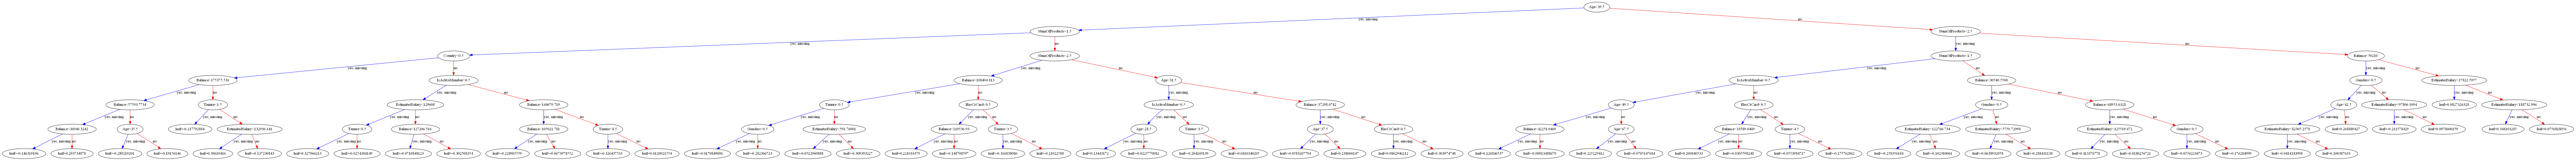

In [48]:
fig, ax = plt.subplots(figsize=(300, 300))
xgb.plot_tree(xgb_model, num_trees=4, ax=ax)
fig1 = plt.gcf()
plt.show()
fig1.savefig("tree.png", dpi=100)

In [13]:
pickle.dump(xgb_model, open("xgb_model.pkl", 'wb'))

pickle.dump(Df_col, open("columns.pkl", 'wb'))